# Решение уравнения Навье-Сткоса в одномерном случае с помощью нейронных сетей

Код под решение одномерного уравнения Навье-Стокса для сжимаемой ньютоновской жидкости.
Все константы и граничные и начальные условия принять единичными.
Реализовать решение обезразмеренного уравнения Навье-Стокса.


$$
\begin{aligned}

    \frac{{\partial u}}{{\partial t}} + \frac{{\partial u}}{{\partial x}} - \frac{\nu}{\rho} \frac{{\partial^2 u}}{{\partial x^2}} = - \frac{{\partial p}}{{\partial x}}\\

    u(0,x) &=1,                  \quad &&\quad x \in [0,1],\\
    u(t,0) = u(t,1) &= 1,         \quad &&\quad t \in (0,1].
    
\end{aligned}
$$


In [33]:
import tensorflow as tf
import numpy as np

FLOAT_32 = 'float32'


# Определение базовых классов

In [34]:
class PINN_Model(tf.keras.Model):
    def __init__(self,
                 t_boundaries,
                 x_boundaries,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim

        self.t_lower_boundary = t_boundaries[0]
        self.t_upper_boundary = t_boundaries[1]

        self.x_lower_boundary = x_boundaries[0]
        self.x_upper_boundary = x_boundaries[1]

        T = self.t_upper_boundary - self.t_lower_boundary
        L = self.x_upper_boundary - self.x_lower_boundary
        M = tf.constant([T, L], dtype=FLOAT_32)
        self.scale = tf.keras.layers.Lambda(lambda x: x / M)

        self.hidden = [tf.keras.layers.Dense(
            units=num_neurons_per_layer,
            activation=tf.keras.activations.get(activation),
            kernel_initializer=kernel_initializer
        ) for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)


In [35]:
class Base_PINN_Solver:
    def __init__(self, model, X_r):
        self.model = model
        self.t = X_r[:, 0:1]
        self.x = X_r[:, 1:2]
        self.losses = []

    def get_result(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.t)
            tape.watch(self.x)

            u = self.model(tf.stack([self.t[:, 0], self.x[:, 0]], axis=1))
            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape

        return self.func(self.t, self.x, u, u_t, u_x, u_xx)

    @staticmethod
    def func(t, x, u, u_t, u_x, u_xx):
        raise "override this method."

    def loss_function(self, X, u):
        result = self.get_result()
        loss = tf.reduce_mean(tf.square(result))

        for i in range(len(X)):
            u_predict = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_predict))

        return loss

    def get_gradient_with_loss(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_function(X, u)

        gradient = tape.gradient(loss, self.model.trainable_variables)

        del tape

        return loss, gradient

    def solve(self, optimizer, X, u, num_epochs=1001):

        @tf.function
        def train_step():
            loss, gradient = self.get_gradient_with_loss(X, u)
            optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))
            return loss

        step = 0
        for i in range(num_epochs):
            loss = train_step()
            current_loss = loss.numpy()
            self.losses.append(current_loss)
            step += 1

            if step % 500 == 0:
                print('It {:05d}: loss = {:10.8e}'.format(step, current_loss))

    def plot_solution(self, **kwargs):
        num_of_elements = 600
        t_space = np.linspace(self.model.t_lower_boundary, self.model.t_upper_boundary, num_of_elements + 1)
        x_space = np.linspace(self.model.x_lower_boundary, self.model.x_upper_boundary, num_of_elements + 1)
        T, X = np.meshgrid(t_space, x_space)
        Xgrid = np.vstack([T.flatten(), X.flatten()]).T
        u_predict = self.model(tf.cast(Xgrid, FLOAT_32))
        U = u_predict.numpy().reshape(num_of_elements + 1, num_of_elements + 1)
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35, 35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.losses)), self.losses, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax


$$
\begin{aligned}

    \frac{{\partial u}}{{\partial t}} + \frac{{\partial u}}{{\partial x}} - \frac{\nu}{\rho} \frac{{\partial^2 u}}{{\partial x^2}} = - \frac{{\partial p}}{{\partial x}}\\
    
    \begin{aligned}
    \nu - вязкость\\ \rho - плотность\\ p - давление 
    \end{aligned}


\end{aligned}
$$

In [36]:
class Navier_Stokes_1D_PINN_Solver(Base_PINN_Solver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @staticmethod
    def func(t, x, u, u_t, u_x, u_xx):
        rho = 0.1
        v = 0.1
        p_x = 0 # если давление постоянное, то производная ноль, а для сжимаемой жидкости p -  функция
        return u_t + u * u_x * - v / rho * u_xx + 1 / rho * p_x


# начальное условие / граничное условие
def fun_u_initial_and_boundary(t):
    n = t.shape[0]
    return tf.ones((n, 1), dtype=FLOAT_32)


# Инициализация данных

In [37]:
N = 50
N_r = 10000

t_min, t_max = 0., 1.
x_min, x_max = 0., 1.

t_boundaries = [t_min, t_max]
x_boundaries = [x_min, x_max]

tf.random.set_seed(0)

t_0 = tf.zeros((N, 1), dtype=FLOAT_32)
x_0 = tf.random.uniform((N, 1), x_min, x_max, dtype=FLOAT_32)
u_x_0 = fun_u_initial_and_boundary(x_0)

t_b = tf.random.uniform((N, 1), t_min, t_max, dtype=FLOAT_32)
x_b = x_min + (x_max - x_min) * tf.keras.backend.random_bernoulli((N, 1), 0.5, dtype=FLOAT_32)
u_x_b = fun_u_initial_and_boundary(x_0)

X_b = tf.concat([t_b, x_b], axis=1)
X_0 = tf.concat([t_0, x_0], axis=1)

t_r = tf.random.uniform((N_r, 1), t_min, t_max, dtype=FLOAT_32)
x_r = tf.random.uniform((N_r, 1), x_min, x_max, dtype=FLOAT_32)
X_r = tf.concat([t_r, x_r], axis=1)

X_data = [X_0, X_b]
u_data = [u_x_0, u_x_b]

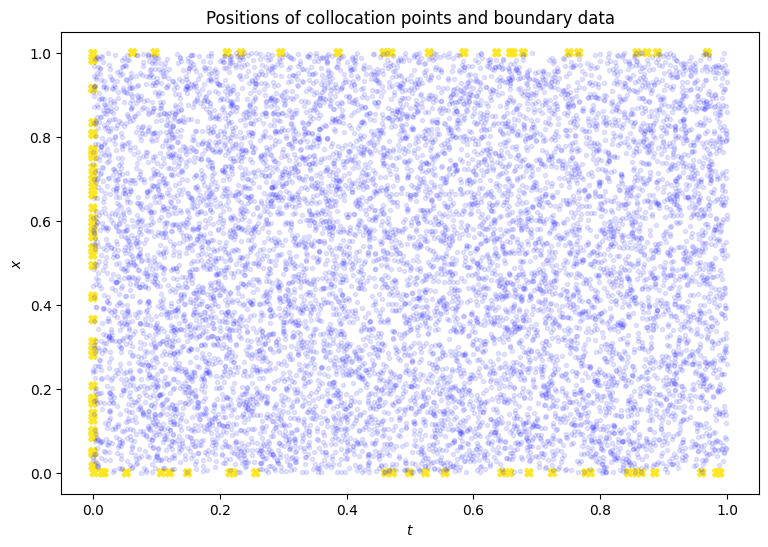

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0, x_0, c=u_x_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_x_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='b', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

# Обучение модели

In [39]:
model = PINN_Model(t_boundaries, x_boundaries)
model.build(input_shape=(None, 2))

solver = Navier_Stokes_1D_PINN_Solver(model, X_r)

In [40]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000, 7000], [1e-1, 1e-2, 1e-3])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

solver.solve(optimizer, X_data, u_data, num_epochs=10001)

It 00500: loss = 4.66854226e-06
It 01000: loss = 2.43076647e-06
It 01500: loss = 1.38686210e-06
It 02000: loss = 8.36646905e-07
It 02500: loss = 5.24146174e-07
It 03000: loss = 3.36040017e-07
It 03500: loss = 3.19505887e-07
It 04000: loss = 3.00742983e-07
It 04500: loss = 2.79096980e-07
It 05000: loss = 2.54607187e-07
It 05500: loss = 2.27830867e-07
It 06000: loss = 1.99430815e-07
It 06500: loss = 1.70394060e-07
It 07000: loss = 1.41725977e-07
It 07500: loss = 1.38657128e-07
It 08000: loss = 1.34971017e-07
It 08500: loss = 1.30310553e-07
It 09000: loss = 1.24641161e-07
It 09500: loss = 1.17907881e-07
It 10000: loss = 1.09950477e-07


<Axes: xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

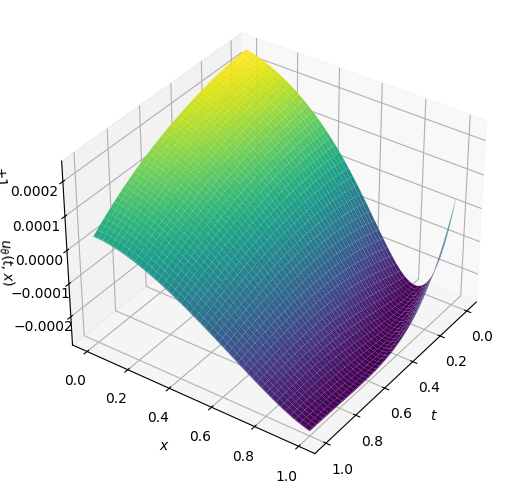

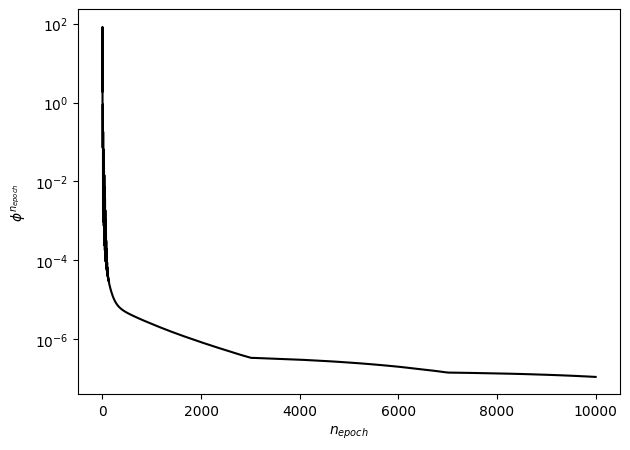

In [42]:
solver.plot_solution()
solver.plot_loss_history()